# Задание 3: Эксперименты и анализ

## 3.1. Исследование гиперпараметров

### Данные с предыдущих заданий

In [43]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import v2
import torchvision.transforms as tf

import pandas as pd
import json

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

from sklearn.compose import ColumnTransformer

class CustomCSVDataset(Dataset):
    def __init__(self, config_path: str = None, **kwargs):
        if config_path:
            self.config = self._load_config(config_path)
        else:
            self.config = kwargs

        self.data = pd.read_csv(
            self.config['csv_param']['path'],
            sep=self.config['csv_param']['sep'],
            header=self.config['csv_param']['header'],
            names=self.config['csv_param']['names'],
            usecols=self.config['csv_param']['usecols'],
            skiprows=self.config['csv_param']['skiprows'],
            nrows=self.config['csv_param']['nrows'],
            index_col=self.config['csv_param']['index_col'],
            dtype=self.config['csv_param']['dtype'],
            na_values=self.config['csv_param']['na_values'],
            encoding=self.config['csv_param']['encoding'],
            converters=self.config['csv_param']['converters']
        )
        self.target_column: list = self.config['target_column']
        self.numeric_cols: list = self.config['numeric_cols']
        self.categorial_cols: list = self.config['categorial_cols']
        self.binary_cols: list = self.config['binary_cols']
        self.normalize_numeric: bool = self.config['normalize_numeric']
        self.scale_range: tuple = self.config['scale_range'] if self.config['scale_range'] else (-1, 1)
        self.transform: callable = self.config['transforms']

        if self.target_column:
            self.y = self.data[self.target_column].values
            self.data = self.data.drop(columns=self.target_column)
        else:
            raise ValueError("В графе 'target_column' пусто. Необходимо ввести столбец с целевой переменной")

        transformers = []

        if self.numeric_cols:
            if self.normalize_numeric:
                scaler = StandardScaler() 
            else:
                scaler = MinMaxScaler(feature_range=scale_range)  
            transformers.append(('num', scaler, self.numeric_cols))

        if self.categorial_cols:
            cat_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
            transformers.append(('categorials', cat_encoder, self.categorial_cols))        

        if self.binary_cols:
            for col in self.binary_cols:
                self.data[col] = self.data[col].astype('float')

        self.preprocessor = ColumnTransformer(
            transformers=transformers,
            remainder='passthrough'
        )

        self.X = self.preprocessor.fit_transform(self.data)

    def _load_config(self, path):
        with open(path, 'r', encoding='utf-8') as file:
            return json.load(file)
    
    def __len__(self):
        return len(self.y)

    def __getitem__(self, index):
        if self.transform:
            return self.transform(self.X)[0][index], torch.tensor(self.y).unsqueeze(0)[0][index]
        return torch.tensor(self.X, dtype=torch.float32)[index], torch.tensor(self.y, dtype=torch.float32).unsqueeze(0)[0][index]

class LinearRegression(torch.nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.linear = torch.nn.Linear(input_size, 1)
        
    def forward(self, x):
        return self.linear(x)

# Конфигурация датасета для линейной регрессии
config_lin_reg = {
    "csv_param": {
        "path": 'data/Student_Performance.csv',
        "sep": ',',
        "header": 'infer',
        "names": None,
        "usecols": None,
        "skiprows": None,
        "nrows": None,
        "index_col": None,
        "dtype": None,
        "na_values": None,
        "encoding": None,
        "converters": None
    },
    "target_column": 'Performance Index',
    "numeric_cols": ['Hours Studied', 'Previous Scores', 'Sleep Hours'],
    "categorial_cols": ['Sample Question Papers Practiced'],
    "binary_cols": ['Extracurricular Activities'],
    "normalize_numeric": True,
    "scale_range": None,
    "transforms": None
}

def visualizer(avg_loss, epochs, filename, **data):
    epochs = range(1, epochs + 1)
    plt.plot(epochs, avg_loss, marker='o', linestyle='-', color='b')
    plt.title(filename)
    plt.xlabel('Эпоха')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.savefig(f"plots/{filename}.jpg")
    plt.show()
    

def train_model(lr, batch_size, optimizer, filename, config_lin_reg=config_lin_reg):
    dataset = CustomCSVDataset(**config_lin_reg)
    
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(
        dataset, 
        [train_size, val_size],
        generator=torch.Generator().manual_seed(42)
    )
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    input_size = train_dataset[0][0].shape[0]
    model = LinearRegression(input_size)
    
    # Параметры регуляризации и ранней остановки
    l1_lambda = 0.001  # Коэффициент для L1
    l2_lambda = 0.01   # Коэффициент для L2 (через weight_decay в оптимизаторе)
    patience = 8       # Для ранней остановки
    best_val_loss = float('inf')
    all_avg_losses = []
    EPOCHS = 50
    counter = 0 
    
    criterion = torch.nn.MSELoss()
    optimizer = optimizer(model.parameters(), lr=lr, weight_decay=l2_lambda)
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True)
    
    for epoch in range(1, EPOCHS + 1):
        model.train()
        train_loss = 0
        for batch_x, y_batch in train_loader:
            optimizer.zero_grad()
            
            y_pred = model(batch_x)
            loss = criterion(y_pred, y_batch.unsqueeze(1))
            
            # Добавление L1-регуляризации
            l1_reg = torch.tensor(0.)
            for param in model.parameters():
                l1_reg += torch.norm(param, 1)
            loss += l1_lambda * l1_reg
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                y_pred = model(X_val)
                loss = criterion(y_pred, y_val.unsqueeze(1))
                val_loss += loss.item()
        
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        all_avg_losses.append(val_loss)
        
        # scheduler.step(val_loss)
        
        # Ранняя остановка
        # if val_loss < best_val_loss:
        #     best_val_loss = val_loss
        #     counter = 0
        #     best_model_state = model.state_dict().copy()
        #     torch.save({
        #             'epoch': epoch,
        #             'model_state_dict': best_model_state,
        #             'optimizer_state_dict': optimizer.state_dict(),
        #             'loss': best_val_loss,
        #         }, 'models/lin_reg_task_2.pth')
        # else:
        #     counter += 1
        #     if counter >= patience:
        #         print(f'Early stopping at epoch {epoch}, best val_loss: {best_val_loss:.4f}')
        #         break
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch:3d} | '
                  f'Train Loss: {train_loss:.4f} | '
                  f'Val Loss: {val_loss:.4f} | '
                  f'LR: {optimizer.param_groups[0]["lr"]:.6f}')
    visualizer(all_avg_losses, EPOCHS, filename)

### lr=0.1, optimizer=Adam, batch_size=16

Epoch  10 | Train Loss: 4.5971 | Val Loss: 4.3041 | LR: 0.100000
Epoch  20 | Train Loss: 4.6060 | Val Loss: 4.3740 | LR: 0.100000
Epoch  30 | Train Loss: 4.6005 | Val Loss: 4.5428 | LR: 0.100000
Epoch  40 | Train Loss: 4.6114 | Val Loss: 4.4749 | LR: 0.100000
Epoch  50 | Train Loss: 4.6152 | Val Loss: 4.3045 | LR: 0.100000


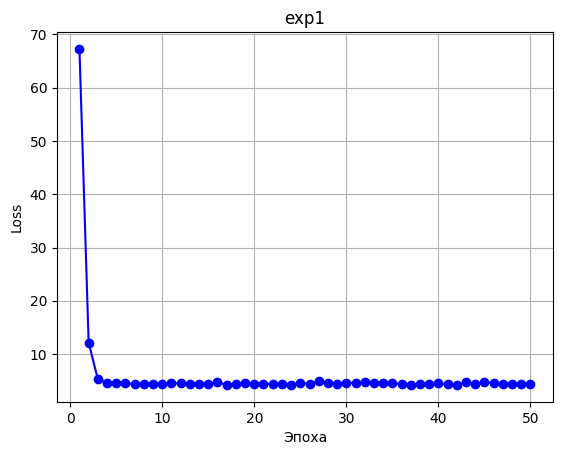

In [44]:
train_model(lr=0.1, optimizer=torch.optim.Adam, batch_size=16, filename='exp1', config_lin_reg=config_lin_reg)

### lr=0.01, optimizer=Adam, batch_size=32

Epoch  10 | Train Loss: 269.9609 | Val Loss: 226.2275 | LR: 0.010000
Epoch  20 | Train Loss: 35.5543 | Val Loss: 30.6141 | LR: 0.010000
Epoch  30 | Train Loss: 5.9671 | Val Loss: 5.2708 | LR: 0.010000
Epoch  40 | Train Loss: 4.7740 | Val Loss: 4.4360 | LR: 0.010000
Epoch  50 | Train Loss: 4.5318 | Val Loss: 4.2364 | LR: 0.010000


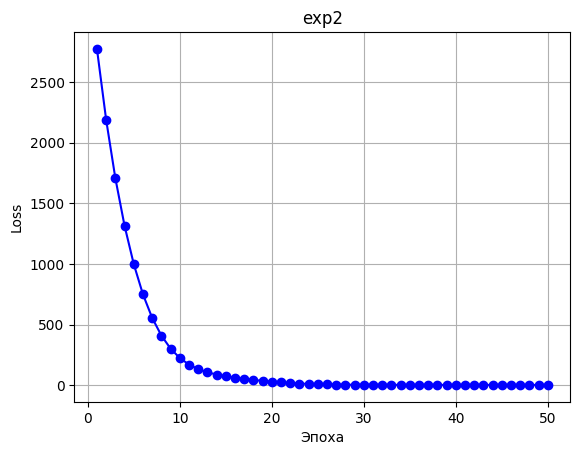

In [32]:
train_model(lr=0.01, optimizer=torch.optim.Adam, batch_size=32, filename='exp2', config_lin_reg=config_lin_reg)

### lr=0.01, optimizer=SGD, batch_size=32

Epoch  10 | Train Loss: 4.4101 | Val Loss: 4.2258 | LR: 0.010000
Epoch  20 | Train Loss: 4.4131 | Val Loss: 4.2496 | LR: 0.010000
Epoch  30 | Train Loss: 4.4174 | Val Loss: 4.2053 | LR: 0.010000
Epoch  40 | Train Loss: 4.4152 | Val Loss: 4.2087 | LR: 0.010000
Epoch  50 | Train Loss: 4.4082 | Val Loss: 4.2080 | LR: 0.010000


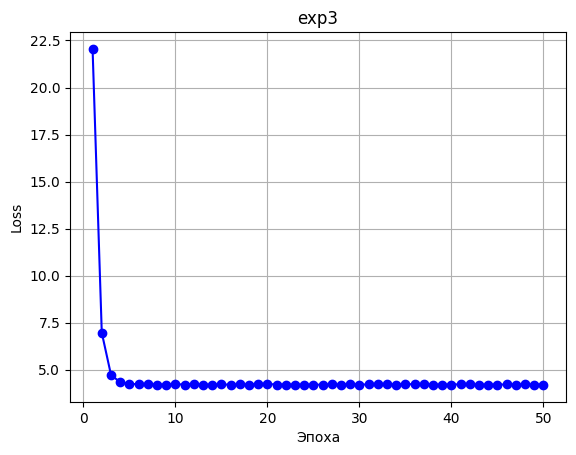

In [33]:
train_model(lr=0.01, optimizer=torch.optim.SGD, batch_size=32, filename='exp3', config_lin_reg=config_lin_reg)

### lr=0.1, optimizer=SGD, batch_size=16

Epoch  10 | Train Loss: 4.5820 | Val Loss: 4.3161 | LR: 0.100000
Epoch  20 | Train Loss: 4.5649 | Val Loss: 4.5030 | LR: 0.100000
Epoch  30 | Train Loss: 4.5727 | Val Loss: 4.2496 | LR: 0.100000
Epoch  40 | Train Loss: 4.5649 | Val Loss: 4.4259 | LR: 0.100000
Epoch  50 | Train Loss: 4.5796 | Val Loss: 4.3115 | LR: 0.100000


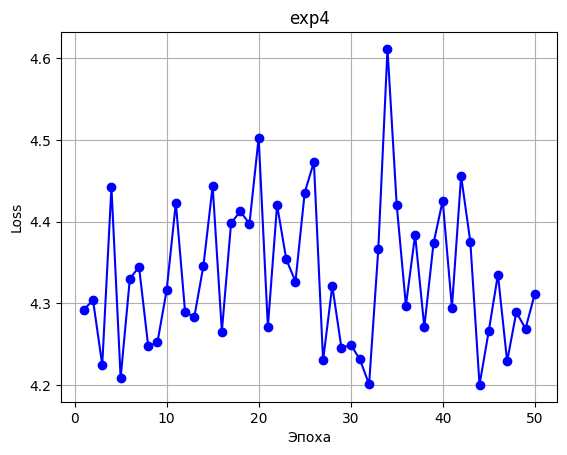

In [34]:
train_model(lr=0.1, optimizer=torch.optim.SGD, batch_size=16, filename='exp4', config_lin_reg=config_lin_reg)

### lr=0.1, optimizer=RMSprop, batch_size=16

Epoch  10 | Train Loss: 4.6026 | Val Loss: 4.3182 | LR: 0.100000
Epoch  20 | Train Loss: 4.6174 | Val Loss: 4.2719 | LR: 0.100000
Epoch  30 | Train Loss: 4.6206 | Val Loss: 4.2626 | LR: 0.100000
Epoch  40 | Train Loss: 4.6128 | Val Loss: 4.3870 | LR: 0.100000
Epoch  50 | Train Loss: 4.6320 | Val Loss: 4.2634 | LR: 0.100000


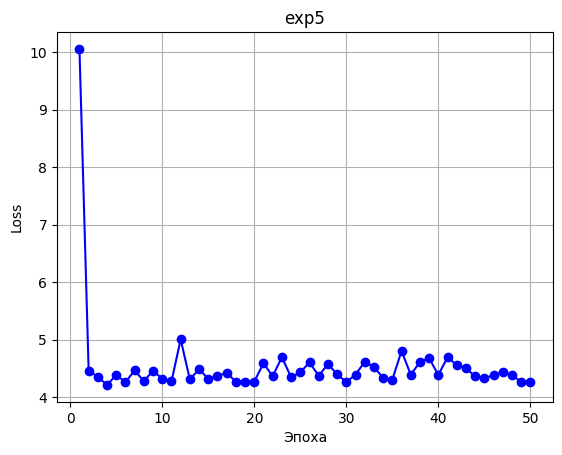

In [35]:
train_model(lr=0.1, optimizer=torch.optim.RMSprop, batch_size=16, filename='exp5', config_lin_reg=config_lin_reg)

### lr=0.01, optimizer=RMSprop, batch_size=32

Epoch  10 | Train Loss: 94.8401 | Val Loss: 70.3649 | LR: 0.010000
Epoch  20 | Train Loss: 4.6394 | Val Loss: 4.2928 | LR: 0.010000
Epoch  30 | Train Loss: 4.5127 | Val Loss: 4.2481 | LR: 0.010000
Epoch  40 | Train Loss: 4.4536 | Val Loss: 4.2240 | LR: 0.010000
Epoch  50 | Train Loss: 4.4288 | Val Loss: 4.2183 | LR: 0.010000


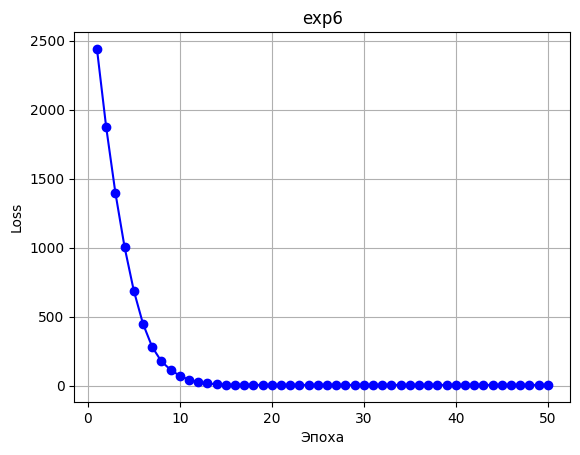

In [36]:
train_model(lr=0.01, optimizer=torch.optim.RMSprop, batch_size=32, filename='exp6', config_lin_reg=config_lin_reg)

## 3.2. Feature Engineering

### Создание признаков

In [51]:
import pandas as pd

df = pd.read_csv("data/Student_Performance.csv")

numeric_features = ['Hours Studied', 'Previous Scores', 'Sleep Hours', 'Sample Question Papers Practiced']

# Добавляем полиномиальный признак
df['Double_Sleep_Hours'] = df['Sleep Hours'] ** 2

# Добавляем взаимодействие между признаки
df['Hours_Studied_x_Sleep_Hours'] = df['Hours Studied'] * df['Sleep Hours']
df['Previous_Scores_x_Sample_Papers'] = df['Previous Scores'] * df['Sample Question Papers Practiced']

# Среднее и дисперсия по числовым признакам для каждой строки
df['Mean'] = df[numeric_features].mean(axis=1)
df['Var'] = df[numeric_features].var(axis=1)

df.to_csv("data/update_Student_Performance.csv", index=False)

### Проверка обучением модели

Epoch  10 | Train Loss: 249.6046 | Val Loss: 209.7019 | LR: 0.010000
Epoch  20 | Train Loss: 34.6868 | Val Loss: 29.9272 | LR: 0.010000
Epoch  30 | Train Loss: 6.2695 | Val Loss: 5.6293 | LR: 0.010000
Epoch  40 | Train Loss: 4.9378 | Val Loss: 4.5676 | LR: 0.010000
Epoch  50 | Train Loss: 4.6329 | Val Loss: 4.3949 | LR: 0.010000


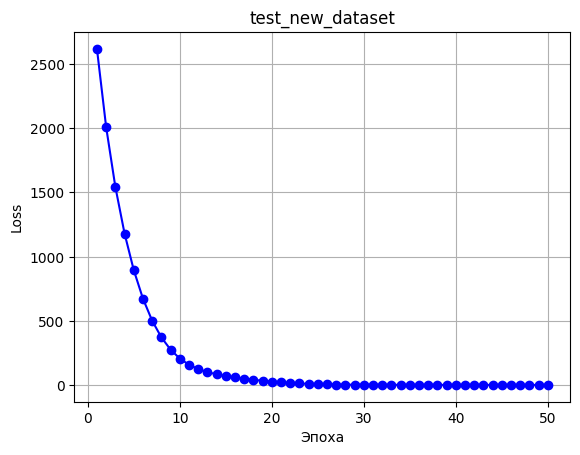

In [48]:
# Параметры возьмём у второго эксперимента, а именно:
# - lr=0.01, 
# - optimizer=torch.optim.Adam, 
# - batch_size=32

new_config = {
    "csv_param": {
        "path": 'data/update_Student_Performance.csv',
        "sep": ',',
        "header": 'infer',
        "names": None,
        "usecols": None,
        "skiprows": None,
        "nrows": None,
        "index_col": None,
        "dtype": None,
        "na_values": None,
        "encoding": None,
        "converters": None
    },
    "target_column": 'Performance Index',
    "numeric_cols": ['Hours Studied', 'Previous Scores', 'Sleep Hours', 'Sample Question Papers Practiced', 
                     'Double_Sleep_Hours', 'Hours_Studied_x_Sleep_Hours', 'Previous_Scores_x_Sample_Papers', 
                     'Mean', 'Var'
                    ],
    "categorial_cols": ['Sample Question Papers Practiced'],
    "binary_cols": ['Extracurricular Activities'],
    "normalize_numeric": True,
    "scale_range": None,
    "transforms": None
}

train_model(lr=0.01, optimizer=torch.optim.Adam, batch_size=32, filename='test_new_dataset', config_lin_reg=new_config)

Исходя из графика и значения функции потерь, можно сделать вывод, что модель обучилась немного хуже, чем на предыдущем датасете, но не критично.
Проверим на других параметрах и сравним с предыдущим соотвествующим экспериментом.

Epoch  10 | Train Loss: 93.2317 | Val Loss: 69.0188 | LR: 0.010000
Epoch  20 | Train Loss: 4.9145 | Val Loss: 4.5800 | LR: 0.010000
Epoch  30 | Train Loss: 4.6365 | Val Loss: 4.4078 | LR: 0.010000
Epoch  40 | Train Loss: 4.5556 | Val Loss: 4.3194 | LR: 0.010000
Epoch  50 | Train Loss: 4.5227 | Val Loss: 4.3081 | LR: 0.010000


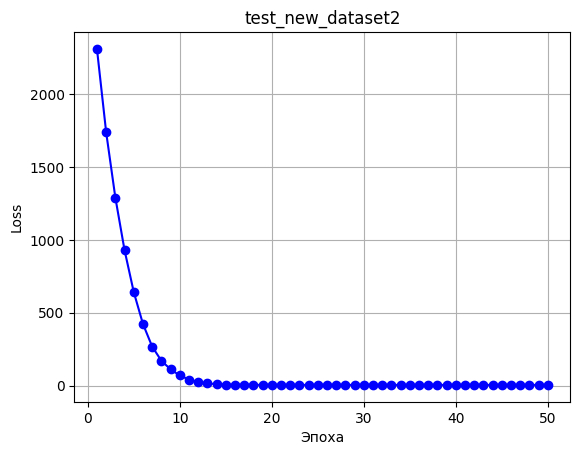

In [50]:
# Параметры exp6
train_model(lr=0.01, optimizer=torch.optim.RMSprop, batch_size=32, filename='test_new_dataset2', config_lin_reg=new_config)

Модель точно также обучилась немного хуже, но не критично.